# Time-Series Analysis and Return Forecasting

In [1]:
# Importing libraries
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import quandl
import os
import warnings;
warnings.filterwarnings('ignore');
load_dotenv()

In /Users/erenturkmenoglu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/erenturkmenoglu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/erenturkmenoglu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/erenturkmenoglu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

True

In [2]:
# Authenticating Quandl API
quandl_api = os.getenv("QUANDL_API_KEY")
quandl.ApiConfig.api_key = quandl_api

## Reading Historical Daily S&P 500 Returns Data

In [3]:
# Fetching S&P 500 Historical Daily Returns since 2000-01-01
spdr = quandl.get('EOD/SPY', start_date='2000-01-01', end_date='2020-12-22')

## Initial Time-Series Plotting

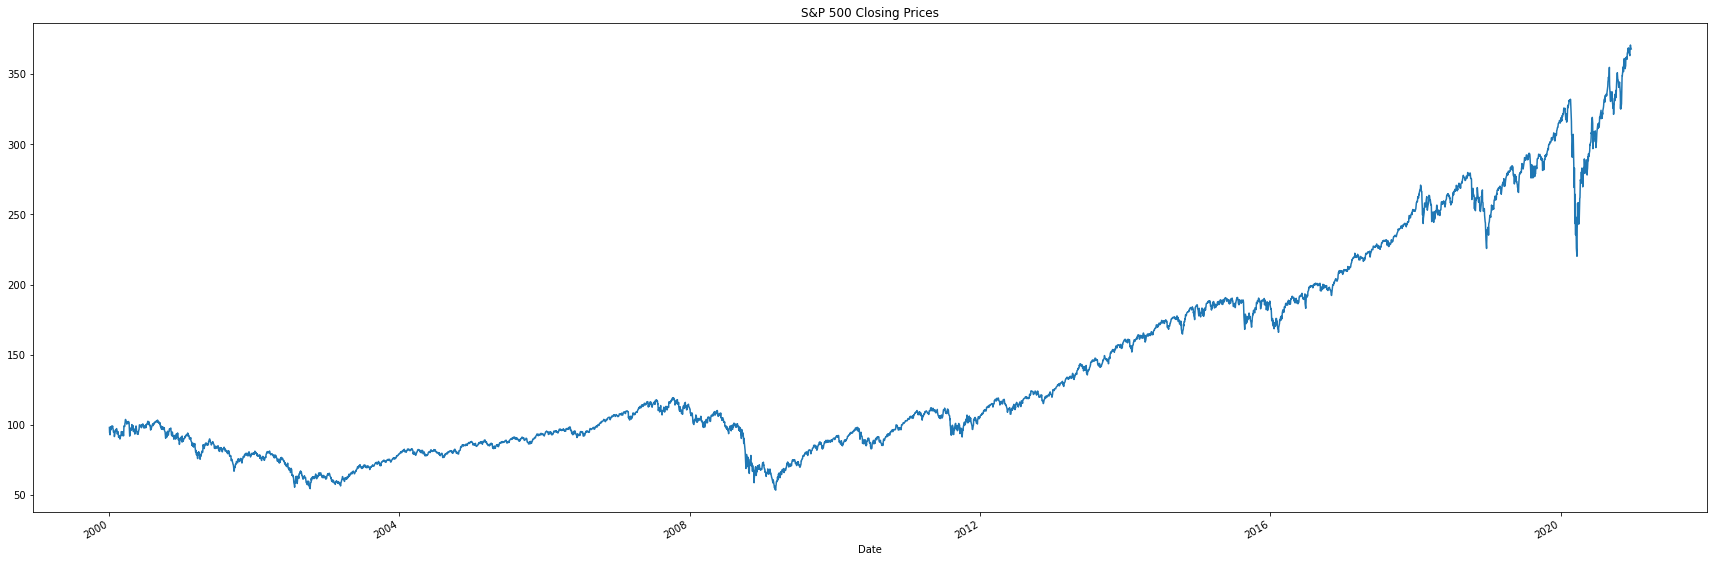

In [4]:
# Plotting S&P 500 Adjusted Closing Prices
spdr.Adj_Close.plot(title='S&P 500 Closing Prices', figsize=(30,10));

## Decomposition Using a Hodrick-Prescott Filter

###### For further information on Hodrick-Prescott Filter, https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html

In [5]:
# Importing statsmodel library
import statsmodels.api as sm

# Applying the Hodrick-Prescott Filter by decomposing the "Adj_Close" price into two separate series:
spdr_noise, spdr_trend = sm.tsa.filters.hpfilter(spdr['Adj_Close'])

In [6]:
# Creating two additional columns for Noise and Trend in the new dataframe
spdr_decomposed = spdr[['Adj_Close']].copy()
spdr_decomposed['Noise'] = spdr_noise
spdr_decomposed['Trend'] = spdr_trend
spdr_decomposed.head()

,Adj_Close,Noise,Trend
Date,,,
2000-01-03,98.094219,1.331886,96.762332
2000-01-04,94.258132,-2.516839,96.774971
2000-01-05,94.426751,-2.361692,96.788443
2000-01-06,92.909178,-3.892828,96.802006
2000-01-07,98.304993,1.491548,96.813445


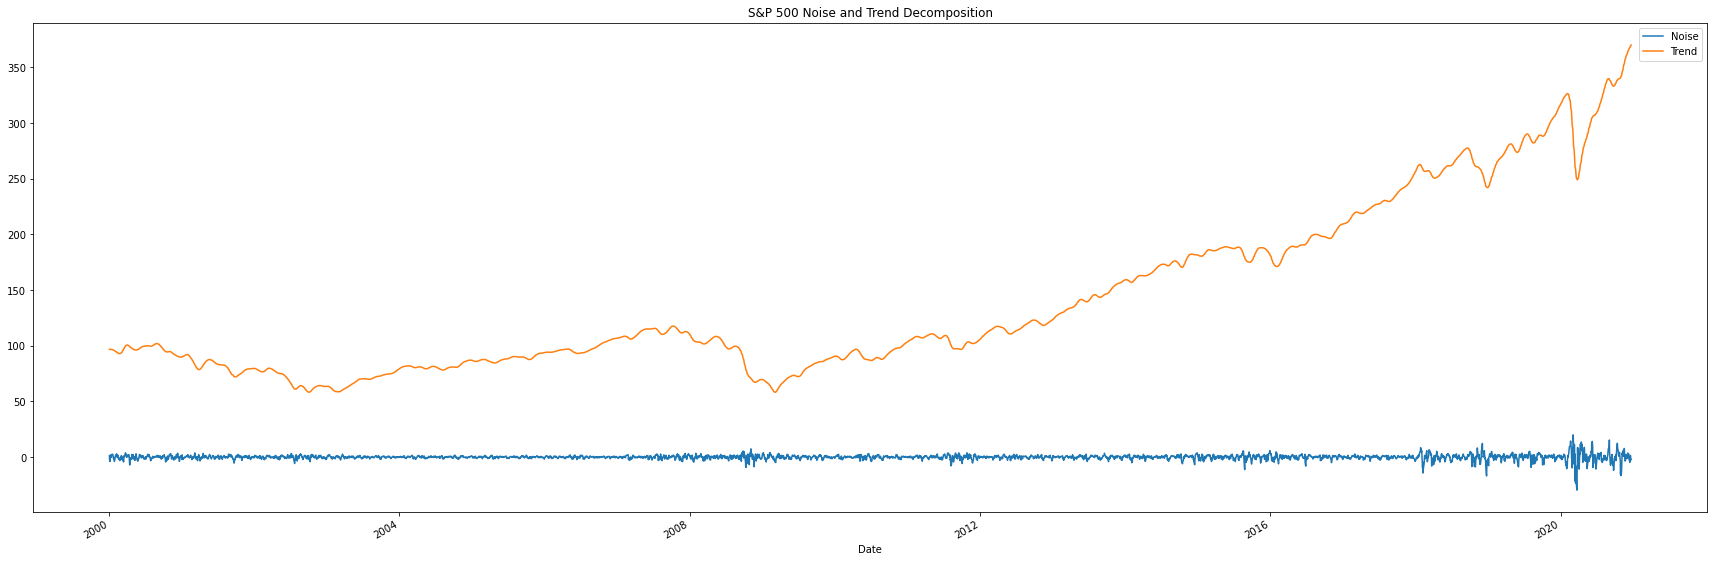

In [7]:
# Plotting Noise and Trend columns 
spdr_decomposed[['Noise', 'Trend']].plot(title='S&P 500 Noise and Trend Decomposition', figsize=(30,10));

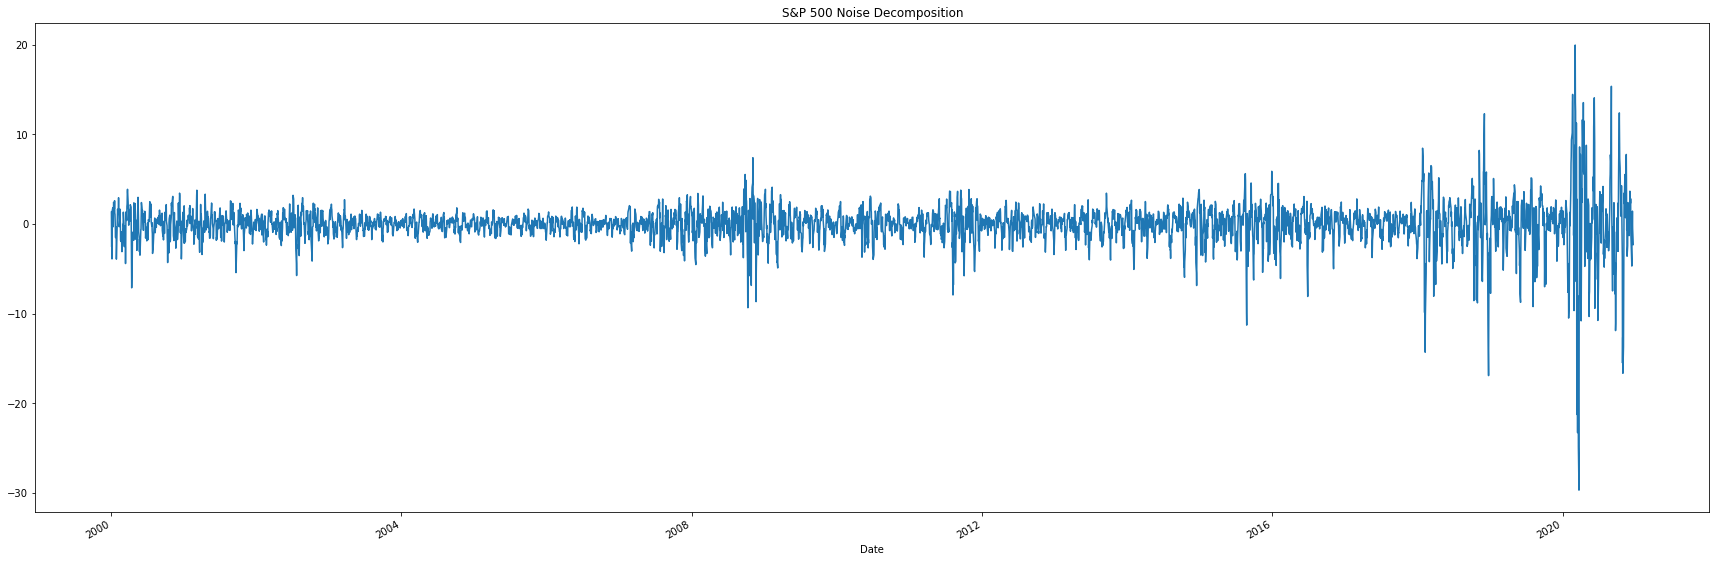

In [8]:
# Plotting Noise column
spdr_decomposed['Noise'].plot(title='S&P 500 Noise Decomposition', figsize=(30,10));

## Forecasting Returns using an ARMA Model

###### For further information on ARMA model, https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html

###### 1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
###### 2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
###### 3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Calculate daily changes as percentage, drop any NaNs, and check the results
daily_returns = (spdr[['Adj_Close']].pct_change()*100)
daily_returns = daily_returns.replace(-np.inf, np.nan).dropna()
daily_returns.tail()

,Adj_Close
Date,
2020-12-15,1.351944
2020-12-16,0.156931
2020-12-17,0.559203
2020-12-18,-0.397593
2020-12-21,-0.357549


In [10]:
from statsmodels.tsa.arima_model import ARMA
# Estimate an ARMA Model using statsmodels
model = ARMA(daily_returns.values, order=(2,1))
# Fit the model
results_arma = model.fit()
# Output the summary results:
results_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5276
Model:                     ARMA(2, 1)   Log Likelihood               -8650.143
Method:                       css-mle   S.D. of innovations              1.247
Date:                Tue, 22 Dec 2020   AIC                          17310.286
Time:                        19:28:39   BIC                          17343.140
Sample:                             0   HQIC                         17321.770
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0330      0.014      2.360      0.018       0.006       0.060
ar.L1.y        0.6601      0.141      4.687      0.000       0.384       0.936
ar.L2.y        0.0479      0.025      1.946      0.052      -0.000       0.096
ma.L1.y       -0.7619      0.140     -5.453      0.000      -1.036      -0.488
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3774           +0.0000j            1.3774            0.0000
AR.2          -15.1714           +0.0000j           15.1714            0.5000
MA.1            1.3125           +0.0000j            1.3125            0.0000
-----------------------------------------------------------------------------
"""

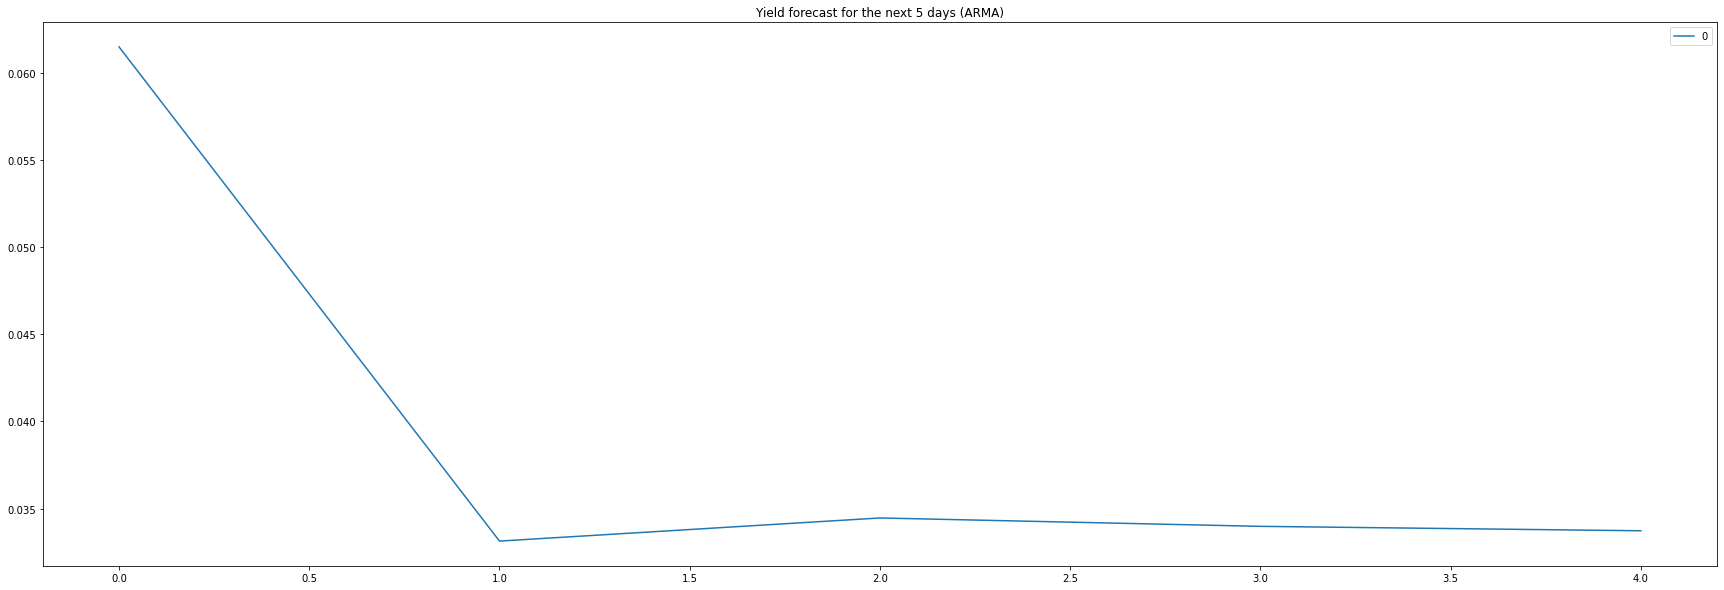

In [11]:
# Plot the next 5 day's price forecast
pd.DataFrame(results_arma.forecast(steps=5)[0]).plot(title='Yield forecast for the next 5 days (ARMA)', figsize=(30,10));

## Forecasting Returns using an ARMA Model

###### For further information on ARIMA model, https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model..ARIMA.html

##### 1. Using the S&P 500 Daily Closing Prices, estimate an ARIMA model.
##### 2. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))

######         P= # of Auto-Regressive Lags, 
######         D= # of Differences (this is usually =1), 
######         Q= # of Moving Average Lags

In [12]:
from statsmodels.tsa.arima_model import ARIMA

In [13]:
# Estimate an ARIMA model
model = ARIMA(spdr_decomposed['Adj_Close'], order=(2, 1, 2))
# Fit the model
results_arima = model.fit()
# Output model summary results:
results_arima.summary()

/Users/erenturkmenoglu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/erenturkmenoglu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj_Close   No. Observations:                 5276
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10558.472
Method:                       css-mle   S.D. of innovations              1.790
Date:                Tue, 22 Dec 2020   AIC                          21128.944
Time:                        19:28:41   BIC                          21168.369
Sample:                             1   HQIC                         21142.724
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0512      0.023      2.218      0.027       0.006       0.096
ar.L1.D.Adj_Close    -1.7298      0.017   -101.756      0.000      -1.763      -1.697
ar.L2.D.Adj_Close    -0.8772      0.016    -53.830      0.000      -0.909      -0.845
ma.L1.D.Adj_Close     1.6242      0.023     69.404      0.000       1.578       1.670
ma.L2.D.Adj_Close     0.7510      0.022     33.641      0.000       0.707       0.795
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9860           -0.4097j            1.0677           -0.4373
AR.2           -0.9860           +0.4097j            1.0677            0.4373
MA.1           -1.0813           -0.4029j            1.1539           -0.4432
MA.2           -1.0813           +0.4029j            1.1539            0.4432
-----------------------------------------------------------------------------
"""

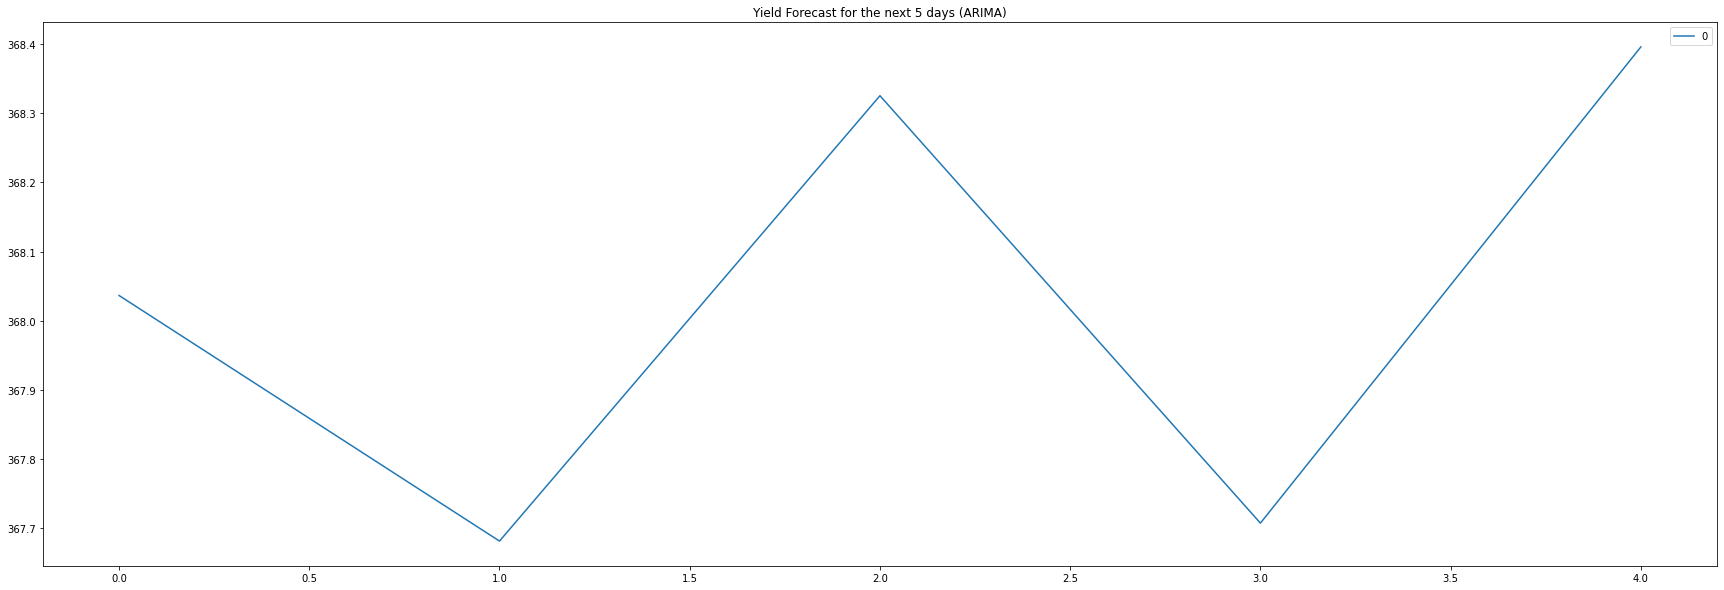

In [14]:
# Plot the next 5 day's price forecast
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="Yield Forecast for the next 5 days (ARIMA)", figsize=(30,10));

## Volatility Forecasting Using GARCH model

###### For further information on GARCH, https://arch.readthedocs.io/en/latest/univariate/introduction.html
#### Using S&P 500's Adjusted Closing Prices, estimate a GARCH model,
###### 1. Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1)
###### 2. Output the GARCH summary table and take note of the p-values of the lags to see if the model is a good fit
###### 3. Plot the 5-day forecast of the volatility

In [15]:
# Importing the GARCH libraries
import arch as arch
from arch import arch_model

In [16]:
# Estimate a GARCH model:
model = arch_model(daily_returns, mean="Zero", vol="GARCH", p=2, q=1, rescale=False)
# Fit the model
results_garch = model.fit(disp="off")
# Summarize the model results
results_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              Adj_Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7273.07
Distribution:                  Normal   AIC:                           14554.1
Method:            Maximum Likelihood   BIC:                           14580.4
                                        No. Observations:                 5276
Date:                Tue, Dec 22 2020   Df Residuals:                     5272
Time:                        19:28:44   Df Model:                            4
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0285  6.612e-03      4.313  1.607e-05 [1.556e-02,4.148e-02]
alpha[1]       0.0806  2.138e-02      3.771  1.629e-04   [3.872e-02,  0.123]
alpha[2]       0.0630  2.679e-02      2.351  1.870e-02   [1.048e-02,  0.115]
beta[1]        0.8357  1.843e-02     45.353      0.000     [  0.800,  0.872]
============================================================================

Covariance estimator: robust
"""

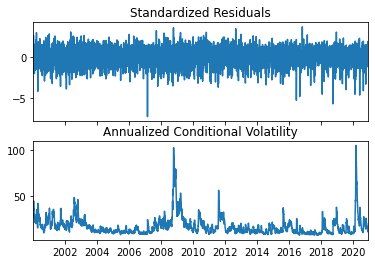

In [17]:
# Plotting the results_garch
fig = results_garch.plot(annualize='D')

In [18]:
# Find the last day of the dataset
last_day = daily_returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-12-21'

In [19]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results_garch.forecast(start=last_day, horizon=forecast_horizon)
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-12-21,11.31411,11.247919,11.453431,11.63452,11.810466


In [20]:
final = intermediate.dropna().T
final.head()

Date,2020-12-21
h.1,11.314110
h.2,11.247919
h.3,11.453431
h.4,11.634520
h.5,11.810466


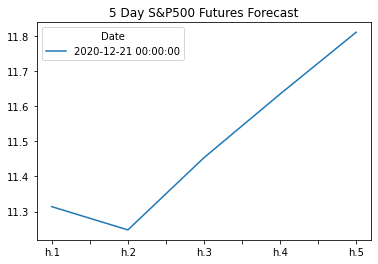

In [21]:
final.plot(title='5 Day S&P500 Futures Forecast');